### stacked map of single galaxies from pair catalog

In [37]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

In [38]:
# --- Settings and constants ---
h = cosmo.h
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0 # Mpc/h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load pairs catalog ---
pairs = pd.read_csv('data/galaxy_pairs_catalog_10hmpc.csv')

# Extract singular galaxies (concatenate both sides of pairs)
l_all = np.concatenate([pairs['l1'], pairs['l2']]) # degrees
b_all = np.concatenate([pairs['b1'], pairs['b2']]) # degrees
z_all = np.concatenate([pairs['z1'], pairs['z2']])
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

ids_all = np.concatenate([pairs['LRG_ID1'], pairs['LRG_ID2']])
ids_all = np.unique(ids_all)
weights = np.ones(len(l_all))  # equal weights
weights = np.concatenate([pairs['w1'], pairs['w2']])

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

Stacking galaxies:   0%|          | 0/26898 [00:00<?, ?it/s]

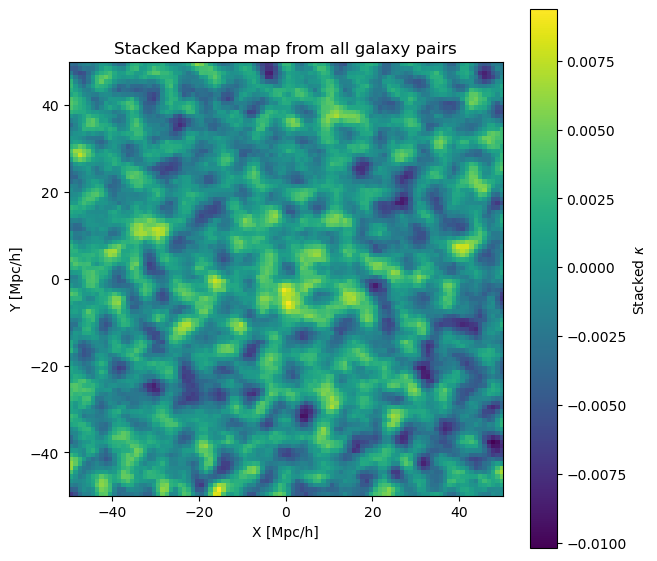

In [39]:
# --- Run stacking ---
kappa_stack = stack_kappa(l_all, b_all, D_all, weights)
# Plot stacked map
plt.figure(figsize=(7, 7))
im = plt.imshow(kappa_stack, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title('Stacked Kappa map from all galaxy pairs')
plt.show()

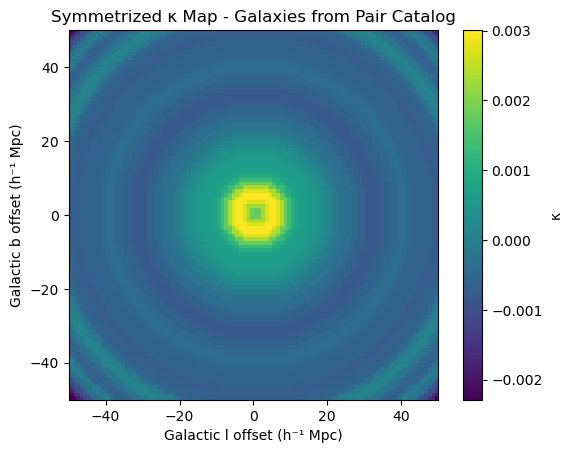

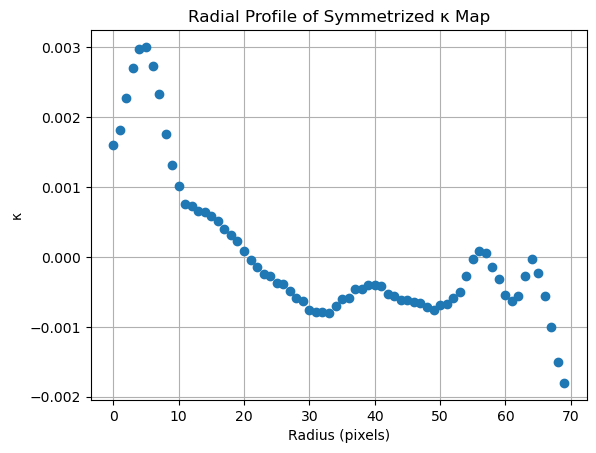

(array([ 1.60215557e-03,  1.81750033e-03,  2.27799578e-03,  2.70612380e-03,
         2.97864132e-03,  3.00670486e-03,  2.73965271e-03,  2.33338715e-03,
         1.76546486e-03,  1.31621382e-03,  1.01196537e-03,  7.62079221e-04,
         7.26980406e-04,  6.64415342e-04,  6.37556780e-04,  5.87507140e-04,
         5.14246381e-04,  4.05805730e-04,  3.19650851e-04,  2.26129084e-04,
         9.18065089e-05, -4.69922025e-05, -1.44621214e-04, -2.42442816e-04,
        -2.72750042e-04, -3.77372657e-04, -3.92763434e-04, -4.82333887e-04,
        -5.85176490e-04, -6.29461035e-04, -7.62994126e-04, -7.83930239e-04,
        -7.85285491e-04, -7.98405508e-04, -7.05276051e-04, -6.00982959e-04,
        -5.82029166e-04, -4.51207875e-04, -4.52891931e-04, -3.99515659e-04,
        -3.95113473e-04, -4.10869368e-04, -5.25656136e-04, -5.63861488e-04,
        -6.11277792e-04, -6.12741014e-04, -6.37500381e-04, -6.62644001e-04,
        -7.17771193e-04, -7.54247135e-04, -6.84842138e-04, -6.72905515e-04,
        -5.8

In [40]:
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_smooth)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - Galaxies from Pair Catalog")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map", zoom=70)

Stacking galaxies:   0%|          | 0/22064 [00:00<?, ?it/s]

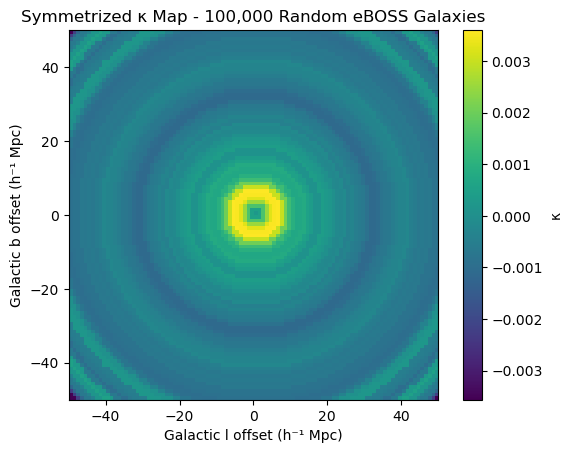

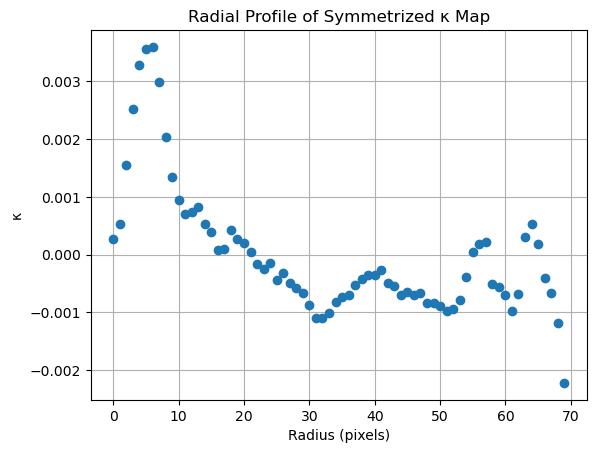

(array([ 2.69035870e-04,  5.27988736e-04,  1.56080900e-03,  2.52555078e-03,
         3.28709575e-03,  3.55399051e-03,  3.59861616e-03,  2.98471883e-03,
         2.04564687e-03,  1.33949460e-03,  9.41100057e-04,  7.10278537e-04,
         7.36202105e-04,  8.23513110e-04,  5.30539570e-04,  3.87910624e-04,
         7.39212381e-05,  9.51987477e-05,  4.34829566e-04,  2.71508467e-04,
         2.08419542e-04,  3.89949797e-05, -1.62615180e-04, -2.55606528e-04,
        -1.42936399e-04, -4.30767100e-04, -3.24353094e-04, -4.89497172e-04,
        -5.73953518e-04, -6.66423684e-04, -8.67572779e-04, -1.09196196e-03,
        -1.09130178e-03, -1.00464906e-03, -8.12887834e-04, -7.34920210e-04,
        -7.04739643e-04, -5.26063747e-04, -4.15352502e-04, -3.42524137e-04,
        -3.44073273e-04, -2.59690870e-04, -4.84465471e-04, -5.48632510e-04,
        -7.02363275e-04, -6.36872822e-04, -6.99851711e-04, -6.67642361e-04,
        -8.33291862e-04, -8.30977328e-04, -8.82420042e-04, -9.82047127e-04,
        -9.3

In [41]:
# import numpy as np
# import healpy as hp
# import matplotlib.pyplot as plt
# from astropy.cosmology import Planck18 as cosmo
# from astropy.io import fits
# from scipy.ndimage import gaussian_filter

# --- Settings and constants ---
h = cosmo.h
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0 # Mpc/h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

# --- Load κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Load original eBOSS catalog ---
real_file = "data/eBOSS/eBOSS_LRG_clustering_data-NGC-vDR16.fits"
with fits.open(real_file) as hd:
    cat = hd[1].data
cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
ids_subset = ids_all #[x for x in ids_all if x % 2 == 1]  # even IDs
include = [(x['LRG_ID'] in ids_subset) for x in cat]
cat = cat[include]
z_all = cat['Z']
ra_all = cat['RA']
dec_all = cat['DEC']

from helper import fast_icrs_to_galactic

l_all, b_all = fast_icrs_to_galactic(ra_all, dec_all)
D_all = cosmo.comoving_distance(z_all).value * h # Mpc/h

# --- Select 100,000 random galaxies ---
num_random = 100000
total_gal = len(l_all)
indices = np.random.choice(total_gal, min(num_random, total_gal), replace=False)

l_rand = l_all[indices]
b_rand = b_all[indices]
D_rand = D_all[indices]
weights_rand = np.ones(len(l_rand))

# --- Stack kappa ---
def stack_kappa(l_arr, b_arr, D_arr, weights):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(l_arr)), desc="Stacking galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_w += w

    κ_mean = np.zeros_like(sum_w)
    valid = sum_w > 0
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    return κ_mean.reshape(grid_size, grid_size)

# --- Run stacking ---
kappa_stack = stack_kappa(l_rand, b_rand, D_rand, weights_rand)
kappa_smooth = gaussian_filter(kappa_stack, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack)

plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title("Symmetrized κ Map - 100,000 Random eBOSS Galaxies")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title="Radial Profile of Symmetrized κ Map", zoom=70)